In [9]:
from skimage import data, util
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import scipy
import os
import numpy as np
filename = os.path.join(os.getcwd(), 'coins2.png')
from skimage import io
img = io.imread(filename)

In [ ]:
def pixelcount(regionmask):
    return np.sum(regionmask)

C:\Users\blasz\AppData\Local\Temp\ipykernel_20808\1056018145.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


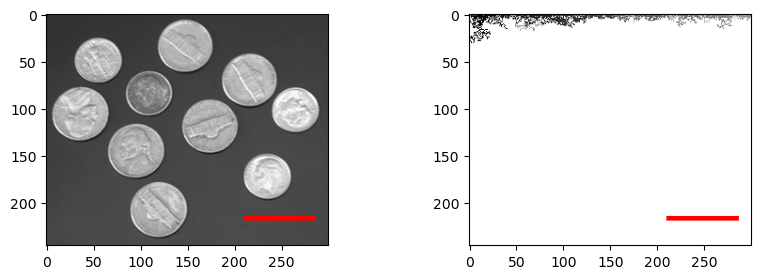

In [10]:
# img = util.img_as_ubyte(data.coins()) > 110
label_img = label(img, connectivity=img.ndim)
props = regionprops(label_img)

props = regionprops(label_img, extra_properties=(pixelcount,))

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2,1)
ax[1] = plt.subplot(1, 2, 2, sharex=ax[0], sharey=ax[0])

ax[0].imshow(img)
ax[1].imshow(label_img)

In [13]:
props[0].pixelcount
props[1]['pixelcount']

3